In [21]:
# !/usr/bin/env python
# -*- coding:utf-8 -*-
import pandas as pd
import numpy as np
import datetime
import io
import re
import itertools
import collections
from pylab import rcParams
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [22]:
raw_data_df = pd.read_excel("input/2021-11-09_promoV8NET-logdata.xlsx")
#raw_data_df = pd.read_excel("input/Taiyoubuhinten_v8LOG.xlsx")
#raw_data_df = pd.read_excel("input/Engineer_v8LOG.xlsx")
# 月日, 時刻カラムは必ず使用する為, カラム使用の判別に用いない
df = raw_data_df.drop(["月日", "時刻"], axis=1)
df.head()

,サーバ,クライアント,グローバルIP,ローカルIP,ポート,HTTPモード,コマンド,エラー,PID,ログインPID,...,アクセス状況,受信時間,受信サイズ,受信数,返却数,返却サイズ,処理時間,応答時間,入力値,パラメータ等
0,sakura,NaN,3.115.81.216,NaN,80,G,価格検索（HTTP）,NaN,14200,-1,...,160/1321774/-1,-1,68,5,1,336,1,1,U40B,parHinban=U40B parJunsei=0 parMakerNo=0
1,sakura,NaN,3.115.81.216,NaN,80,G,価格検索（HTTP）,NaN,14199,-1,...,159/1321774/-1,-1,68,5,1,336,1,1,U40B,parHinban=U40B parJunsei=0 parMakerNo=0
2,sakura,NaN,3.115.81.216,NaN,80,G,価格検索（HTTP）,NaN,14198,-1,...,158/1321774/-1,-1,72,5,1,340,1,1,MQ513048,parHinban=MQ513048 parJunsei=0 parMakerNo=0
3,sakura,NaN,54.250.12.5,NaN,80,G,互換検索（HTTP）,NaN,14167,-1,...,274/3049825/-1,-1,61,4,0,150,1,1,7289378A00,parHinban=7289378A00 CallHinban=7289378A00
4,sakura,NaN,3.115.81.216,NaN,80,G,価格検索（HTTP）,NaN,14157,-1,...,157/1321756/-1,-1,70,5,1,355,1,1,J9061M,parHinban=J9061M parJunsei=0 parMakerNo=0


In [23]:
"""
カラム毎の欠損率確認
60%以上NULLのカラムは使用しない
"""
null_val = df.isnull().sum()
percent = 100 * df.isnull().sum() / len(df)
data_loss = pd.concat([null_val, percent], axis=1)
data_loss_columns = data_loss.rename(
    columns={0: '欠損数', 1: '欠損率'})
# 60％以上NULLのカラム
drop_col_list = list(data_loss_columns.query('欠損率 > 60').index)  # 入力値の欠損率が55.6%であった為, 本データでは使用する判断

In [24]:
"""
カラム毎の頻度確認
すべて同一の値のカラムは使用しない
"""
not_use_cols_list = []
for col in df.columns:
    df_appearance_rate = pd.DataFrame(df[col].value_counts())
    # すべて同一要素のカラムを取得
    if df_appearance_rate.shape[0] == 1:
        not_use_cols_list.append(col)
not_use_cols_list 

['サーバ', 'ポート', 'HTTPモード', 'ログインPID', '親ユーザ', 'アクセス結果', 'アクセス設定', '受信時間']

In [25]:
"""
手動で削除するカラム
設定ファイルなどしてもよい
"""
drop_cols = [
    "グローバルIP"  # 54.250.12.5, 3.115.81.216の2種類のみで特に見ていない値の為
]

In [26]:
drop_col_list.extend(not_use_cols_list)
# print(drop_col_list)
df = raw_data_df.drop(drop_col_list, axis=1)
df.to_csv("out/use_cols_df.csv", index=False)

In [27]:
df.head()

,月日,時刻,グローバルIP,コマンド,PID,子ユーザ,アクセス状況,受信サイズ,受信数,返却数,返却サイズ,処理時間,応答時間,入力値,パラメータ等
0,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14200,61133205,160/1321774/-1,68,5,1,336,1,1,U40B,parHinban=U40B parJunsei=0 parMakerNo=0
1,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14199,61133205,159/1321774/-1,68,5,1,336,1,1,U40B,parHinban=U40B parJunsei=0 parMakerNo=0
2,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14198,61133205,158/1321774/-1,72,5,1,340,1,1,MQ513048,parHinban=MQ513048 parJunsei=0 parMakerNo=0
3,2021-11-09,16:04:31,54.250.12.5,互換検索（HTTP）,14167,61791403,274/3049825/-1,61,4,0,150,1,1,7289378A00,parHinban=7289378A00 CallHinban=7289378A00
4,2021-11-09,16:04:26,3.115.81.216,価格検索（HTTP）,14157,61133205,157/1321756/-1,70,5,1,355,1,1,J9061M,parHinban=J9061M parJunsei=0 parMakerNo=0


In [28]:
key_list = []
for raw in df["パラメータ等"]:
    # 半角スペースとイコールの間の文字列を取得する
    # \w: アルファベット、アンダーバー、数字
    p = r"(\w+)="
    r = re.findall(p, raw)
    key_list.append(r)
key_list = set(list(itertools.chain.from_iterable(key_list)))
print(key_list)

{'parHinban', 'KurumaInfo', 'parType', 'parHinmokuNos', 'parMakerNos', 'parJunsei', 'parHMCount', 'CallHinban', 'parKurumaNo', 'ParamList', 'parSyadaiNo', 'parMakerNo'}


In [29]:
for key in key_list:
    df['パラメータ等'] = df['パラメータ等'].str.replace(f'{key}', f',{key}')

In [30]:
# 先頭の1文字を削除(先頭の,を削除)
df["パラメータ等"] = df["パラメータ等"].str[1:]

In [31]:
# カンマで分割する
df_param = df['パラメータ等'].str.split(',', expand=True)
df_param

,0,1,2,3,4,5
0,parHinban=U40B,parJunsei=0,parMakerNo=0,None,None,None
1,parHinban=U40B,parJunsei=0,parMakerNo=0,None,None,None
2,parHinban=MQ513048,parJunsei=0,parMakerNo=0,None,None,None
3,parHinban=7289378A00,CallHinban=7289378A00,None,None,None,None
4,parHinban=J9061M,parJunsei=0,parMakerNo=0,None,None,None
...,...,...,...,...,...,...
995,parKurumaNo=141797,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0
996,parKurumaNo=141793,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0
997,parKurumaNo=140451,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0
998,parKurumaNo=136422,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0


In [32]:
df_ = pd.DataFrame()

for col in range(df_param.shape[1]):
    for key in key_list:
        df_[f'{key}_{col}'] = df_param[col].str.match(f'.*{key}=')
        # df_[f'{key}_{col}'] = df_param[col].str.match(f'.*{key}=*')
        df_.loc[df_[f'{key}_{col}'] == True, f'{key}_{col}'] = df_param[col]
df_.head()
df_.to_csv("./out/columns_name.csv")

In [33]:
# FalseをNullに置換
df_.replace(False, np.nan, inplace=True)
# すべて欠損の列を削除
df_.dropna(how='all', axis=1, inplace=True)
# サフィックスを削除
cols = df_.columns.str.replace('_.*', '', regex=True)
# カラム名変更
df_.columns = cols
df_.columns
df_

,parHinban,parKurumaNo,ParamList,KurumaInfo,parType,parJunsei,parHMCount,CallHinban,parHinmokuNos,CallHinban,parMakerNo,parMakerNos,parSyadaiNo
0,parHinban=U40B,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,NaN,NaN,parMakerNo=0,None,None
1,parHinban=U40B,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,NaN,NaN,parMakerNo=0,None,None
2,parHinban=MQ513048,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,NaN,NaN,parMakerNo=0,None,None
3,parHinban=7289378A00,NaN,NaN,NaN,NaN,NaN,NaN,CallHinban=7289378A00,None,None,None,None,None
4,parHinban=J9061M,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,NaN,NaN,parMakerNo=0,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,parKurumaNo=141797,NaN,NaN,NaN,NaN,parHMCount=23,NaN,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0
996,NaN,parKurumaNo=141793,NaN,NaN,NaN,NaN,parHMCount=23,NaN,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0
997,NaN,parKurumaNo=140451,NaN,NaN,NaN,NaN,parHMCount=23,NaN,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0
998,NaN,parKurumaNo=136422,NaN,NaN,NaN,NaN,parHMCount=23,NaN,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0


In [34]:
# 同一カラム名が存在する場合は結合して一つのカラムにする
identifier = df_.columns.to_series().groupby(level=0).transform('cumcount')
identifier

parHinban        0
parKurumaNo      0
ParamList        0
KurumaInfo       0
parType          0
parJunsei        0
parHMCount       0
CallHinban       0
parHinmokuNos    0
CallHinban       1
parMakerNo       0
parMakerNos      0
parSyadaiNo      0
dtype: int64

In [35]:
df_.columns = df_.columns.astype('string') + "_" + identifier.astype('string')
cols = df_.columns
cols

Index(['parHinban_0', 'parKurumaNo_0', 'ParamList_0', 'KurumaInfo_0',
       'parType_0', 'parJunsei_0', 'parHMCount_0', 'CallHinban_0',
       'parHinmokuNos_0', 'CallHinban_1', 'parMakerNo_0', 'parMakerNos_0',
       'parSyadaiNo_0'],
      dtype='object')

In [36]:
# Indexのサフィックスの数値から結合
# サフィックスの数値が0であれば何もしない
merge_col_list=[]
for col in df_.columns:
    # アンダーバーの数値が０なら何もしない
    if "_0" in col:
        pass
    # _数値が0以外であれば数値回だけ結合する
    else:
        col = col.split('_')[0]
        merge_col_list.append(col)

# サフィックスの数値の最大値取得して、例えば1なら1回結合する
merge_col_list

['CallHinban']

In [37]:
# リストcolsを昇順に並び替える
l = cols.tolist()
l.sort()
print(l)
# サフィックスの最大値取得
sf = 2 # 最大値2とする

for col in cols:
    print(f'{col}')

['CallHinban_0', 'CallHinban_1', 'KurumaInfo_0', 'ParamList_0', 'parHMCount_0', 'parHinban_0', 'parHinmokuNos_0', 'parJunsei_0', 'parKurumaNo_0', 'parMakerNo_0', 'parMakerNos_0', 'parSyadaiNo_0', 'parType_0']
parHinban_0
parKurumaNo_0
ParamList_0
KurumaInfo_0
parType_0
parJunsei_0
parHMCount_0
CallHinban_0
parHinmokuNos_0
CallHinban_1
parMakerNo_0
parMakerNos_0
parSyadaiNo_0


In [38]:
print(merge_col_list)
# 動的にサフィックスの数値を取得

# 
sa=1

print(cols)


# _0と_1を結合

# _2を結合


for col in merge_col_list:
    #print(col)
    #print(range(sa))
    for s in range(sa):
        a = str(s)
        b = str(s+1)
        print(a)
        print(b)
        df_[f'{col}'] = df_[f'{col}_{a}'].str.cat(df_[f'{col}_{b}'], na_rep='')
        # カラム削除
        df_.drop([f"{col}_{a}", f"{col}_{b}"], axis=1, inplace=True)
df_

['CallHinban']
Index(['parHinban_0', 'parKurumaNo_0', 'ParamList_0', 'KurumaInfo_0',
       'parType_0', 'parJunsei_0', 'parHMCount_0', 'CallHinban_0',
       'parHinmokuNos_0', 'CallHinban_1', 'parMakerNo_0', 'parMakerNos_0',
       'parSyadaiNo_0'],
      dtype='object')
0
1


,parHinban_0,parKurumaNo_0,ParamList_0,KurumaInfo_0,parType_0,parJunsei_0,parHMCount_0,parHinmokuNos_0,parMakerNo_0,parMakerNos_0,parSyadaiNo_0,CallHinban
0,parHinban=U40B,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,parMakerNo=0,None,None,
1,parHinban=U40B,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,parMakerNo=0,None,None,
2,parHinban=MQ513048,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,parMakerNo=0,None,None,
3,parHinban=7289378A00,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,CallHinban=7289378A00
4,parHinban=J9061M,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,parMakerNo=0,None,None,
...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,parKurumaNo=141797,NaN,NaN,NaN,NaN,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0,
996,NaN,parKurumaNo=141793,NaN,NaN,NaN,NaN,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0,
997,NaN,parKurumaNo=140451,NaN,NaN,NaN,NaN,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0,
998,NaN,parKurumaNo=136422,NaN,NaN,NaN,NaN,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0,


In [39]:
df_

,parHinban_0,parKurumaNo_0,ParamList_0,KurumaInfo_0,parType_0,parJunsei_0,parHMCount_0,parHinmokuNos_0,parMakerNo_0,parMakerNos_0,parSyadaiNo_0,CallHinban
0,parHinban=U40B,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,parMakerNo=0,None,None,
1,parHinban=U40B,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,parMakerNo=0,None,None,
2,parHinban=MQ513048,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,parMakerNo=0,None,None,
3,parHinban=7289378A00,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,CallHinban=7289378A00
4,parHinban=J9061M,NaN,NaN,NaN,NaN,parJunsei=0,NaN,NaN,parMakerNo=0,None,None,
...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,parKurumaNo=141797,NaN,NaN,NaN,NaN,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0,
996,NaN,parKurumaNo=141793,NaN,NaN,NaN,NaN,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0,
997,NaN,parKurumaNo=140451,NaN,NaN,NaN,NaN,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0,
998,NaN,parKurumaNo=136422,NaN,NaN,NaN,NaN,parHMCount=23,parHinmokuNos=1020/1020/1020/1021/1021/1021/10...,NaN,parMakerNos=3200/2260/4060/3200/2260/4060/2260...,parSyadaiNo=0,


In [40]:
# サフィックスを削除
cols = df_.columns.str.replace('_.*', '', regex=True)
# カラム名変更
df_.columns = cols
# パラメータ名= を削除
for key in key_list:
    df_[f"{key}"] = df_[f"{key}"].str.replace(f"{key}=", "")
    #print(df_[f"{key}"])


In [41]:
df_

,parHinban,parKurumaNo,ParamList,KurumaInfo,parType,parJunsei,parHMCount,parHinmokuNos,parMakerNo,parMakerNos,parSyadaiNo,CallHinban
0,U40B,NaN,NaN,NaN,NaN,0,NaN,NaN,0,None,None,
1,U40B,NaN,NaN,NaN,NaN,0,NaN,NaN,0,None,None,
2,MQ513048,NaN,NaN,NaN,NaN,0,NaN,NaN,0,None,None,
3,7289378A00,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,7289378A00
4,J9061M,NaN,NaN,NaN,NaN,0,NaN,NaN,0,None,None,
...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,141797,NaN,NaN,NaN,NaN,23,1020/1020/1020/1021/1021/1021/1023/1025/1022/1...,NaN,3200/2260/4060/3200/2260/4060/2260/2260/3200/2...,0,
996,NaN,141793,NaN,NaN,NaN,NaN,23,1020/1020/1020/1021/1021/1021/1023/1025/1022/1...,NaN,3200/2260/4060/3200/2260/4060/2260/2260/3200/2...,0,
997,NaN,140451,NaN,NaN,NaN,NaN,23,1020/1020/1020/1021/1021/1021/1023/1025/1022/1...,NaN,3200/2260/4060/3200/2260/4060/2260/2260/3200/2...,0,
998,NaN,136422,NaN,NaN,NaN,NaN,23,1020/1020/1020/1021/1021/1021/1023/1025/1022/1...,NaN,3200/2260/4060/3200/2260/4060/2260/2260/3200/2...,0,


In [42]:
split_cols = []
# /区切りの要素が入るカラムを特定する
for c in cols:
    print(c)
    df_c = df_[df_[c].str.contains("/", na=False)]
    # レコード数取得
    # 0レコード以外カラム名をリストに格納する
    if df_c.shape[0] == 0:
        pass
    else:
        split_cols.append(c)
    #df_c.to_csv(f"./out/contain_slash_{c}.csv")
split_cols

parHinban
parKurumaNo
ParamList
KurumaInfo
parType
parJunsei
parHMCount
parHinmokuNos
parMakerNo
parMakerNos
parSyadaiNo
CallHinban


['parHinban', 'ParamList', 'KurumaInfo', 'parHinmokuNos', 'parMakerNos']

In [43]:
split_cols

['parHinban', 'ParamList', 'KurumaInfo', 'parHinmokuNos', 'parMakerNos']

In [44]:
for col in split_cols:
    df_[f"{col}"] = df_[f"{col}"].fillna("/")
    df_[f"{col}"] = df_[f"{col}"].replace('/', ',', regex=True)
    df_[f"{col}"] = df_[f"{col}"].str.split(',')
    #df_[f"{col}"].to_csv(f"out/{col}.csv", index=False)

In [45]:
df_

,parHinban,parKurumaNo,ParamList,KurumaInfo,parType,parJunsei,parHMCount,parHinmokuNos,parMakerNo,parMakerNos,parSyadaiNo,CallHinban
0,[U40B ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
1,[U40B ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
2,[MQ513048 ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
3,[7289378A00 ],NaN,"[, ]","[, ]",NaN,NaN,NaN,"[, ]",None,"[, ]",None,7289378A00
4,[J9061M ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
...,...,...,...,...,...,...,...,...,...,...,...,...
995,"[, ]",141797,"[, ]","[, ]",NaN,NaN,23,"[1020, 1020, 1020, 1021, 1021, 1021, 1023, 102...",NaN,"[3200, 2260, 4060, 3200, 2260, 4060, 2260, 226...",0,
996,"[, ]",141793,"[, ]","[, ]",NaN,NaN,23,"[1020, 1020, 1020, 1021, 1021, 1021, 1023, 102...",NaN,"[3200, 2260, 4060, 3200, 2260, 4060, 2260, 226...",0,
997,"[, ]",140451,"[, ]","[, ]",NaN,NaN,23,"[1020, 1020, 1020, 1021, 1021, 1021, 1023, 102...",NaN,"[3200, 2260, 4060, 3200, 2260, 4060, 2260, 226...",0,
998,"[, ]",136422,"[, ]","[, ]",NaN,NaN,23,"[1020, 1020, 1020, 1021, 1021, 1021, 1023, 102...",NaN,"[3200, 2260, 4060, 3200, 2260, 4060, 2260, 226...",0,


In [46]:
cols

Index(['parHinban', 'parKurumaNo', 'ParamList', 'KurumaInfo', 'parType',
       'parJunsei', 'parHMCount', 'parHinmokuNos', 'parMakerNo', 'parMakerNos',
       'parSyadaiNo', 'CallHinban'],
      dtype='object')

In [ ]:
split_cols = []
# /区切りの要素が入るカラムを特定する
for c in cols:
    print(c)
    df_c = df_[df_[c].str.contains("/", na=False)]
    # レコード数取得
    # 0レコード以外カラム名をリストに格納する
    if df_c.shape[0] == 0:
        pass
    else:
        split_cols.append(c)
    #df_c.to_csv(f"./out/contain_slash_{c}.csv")
split_cols

In [ ]:
df_

In [ ]:
# カンマ区切りで複数要素が入った列をリストで取得
split_cols

for col in split_cols:
    df_[f"{col}"] = df_[f"{col}"].fillna("/")
    df_[f"{col}"] = df_[f"{col}"].replace('/', ',', regex=True)
    df_[f"{col}"] = df_[f"{col}"].str.split(',')
    print(df_[f"{col}"])




In [ ]:
# 同一カラムが存在する場合は結合して一つのカラムにする
#identifier = df_.columns.to_series().groupby(level=0).transform('cumcount')
#df_.columns = df_.columns.astype('string') + "_" + identifier.astype('string')
#df_['CallHinban_1'].to_csv("out/CallHinban_1.csv", index=False)
#df_['CallHinban_0'].to_csv("out/CallHinban_0.csv", index=False)
#df_['CallHinban'] = df_['CallHinban_0'].str.cat(df_['CallHinban_1'], na_rep='')
# カラム削除
#df_.drop(["CallHinban_0", "CallHinban_1"], axis=1, inplace=True)
# サフィックスを削除
#cols = df_.columns.str.replace('_.*', '', regex=True)
# カラム名変更
#df_.columns = cols
# パラメータ名= を削除
#for key in key_list:
#    df_[f"{key}"] = df_[f"{key}"].str.replace(f"{key}=", "")

In [ ]:
# カンマ区切りで複数要素が入った列を集計
# ParamList, KurumaInfo, parHinmokuNos, parMakerNos
# / を , に変換
#split_cols = [
#    "ParamList", 
#    "KurumaInfo", 
#    "parHinmokuNos", 
#    "parMakerNos"
#]
for col in split_cols:
    df_[f"{col}"] = df_[f"{col}"].fillna("/")
    df_[f"{col}"] = df_[f"{col}"].replace('/', ',', regex=True)
    df_[f"{col}"] = df_[f"{col}"].str.split(',')
    df_[f"{col}"].to_csv(f"out/{col}.csv", index=False)

In [ ]:
df_.to_csv("./out/df_.csv")
df_

## 0. 目的
- V8LOGデータ集計の進捗報告
  - 集計方法の妥当性確認
  - 可視化方法の確認

## 1. 進捗 

### 前処理プログラム作成
- 使用する列の抽出
  - すべてNullのカラムは削除
  - すべて同一のカラムは削除
  - 過半数がNullのカラムは削除
  - 不要な（あまり見ていない）カラムは削除
- 「パラメータ等」列の分割
  - 同一カラムに複数パラメータが入っている為、データ集計しやすいカラム、要素に分割する処理を作成

### 基礎集計
- 単純集計
- 可視化
  - 棒グラフ
  - ヒストグラム
  - 時系列

## 2. 作成中
- 同一子ユーザが短い間隔で検索した場合、除外するまたはまとめる
-　相関のあるカラムの可視化
  - 相関係数、有意差
- 時間を指定して基礎集計、基本統計量を出力、可視化


## 3. 検証ポイント
- レコード数を増やした場合、現在（1000レコード）と異なる特徴はみられるか
- 同一子ユーザが短い間隔で検索した影響を除外した場合、現在と異なる特徴はみられるか
- 相関（有意差）をみたい項目はあるか
- 時系列で比較したい項目はあるか
  - 今回は受信サイズ, 受信数でサンプル可視化
  - 相関の高い項目を時系列で比較してみる等

In [50]:
raw_data_df = df_

## 元データ

In [52]:
raw_data_df.head()

,parHinban,parKurumaNo,ParamList,KurumaInfo,parType,parJunsei,parHMCount,parHinmokuNos,parMakerNo,parMakerNos,parSyadaiNo,CallHinban
0,[U40B ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
1,[U40B ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
2,[MQ513048 ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
3,[7289378A00 ],NaN,"[, ]","[, ]",NaN,NaN,NaN,"[, ]",None,"[, ]",None,7289378A00
4,[J9061M ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,


In [53]:
raw_data_df.columns().head()

TypeError: 'Index' object is not callable

In [54]:
# パラメータ等列
df_.head()

,parHinban,parKurumaNo,ParamList,KurumaInfo,parType,parJunsei,parHMCount,parHinmokuNos,parMakerNo,parMakerNos,parSyadaiNo,CallHinban
0,[U40B ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
1,[U40B ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
2,[MQ513048 ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
3,[7289378A00 ],NaN,"[, ]","[, ]",NaN,NaN,NaN,"[, ]",None,"[, ]",None,7289378A00
4,[J9061M ],NaN,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,


## 前処理済テーブル

In [55]:
df_p = pd.concat([df.drop('パラメータ等', axis=1), df_], axis=1)
df_p.head()

,月日,時刻,グローバルIP,コマンド,PID,子ユーザ,アクセス状況,受信サイズ,受信数,返却数,...,ParamList,KurumaInfo,parType,parJunsei,parHMCount,parHinmokuNos,parMakerNo,parMakerNos,parSyadaiNo,CallHinban
0,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14200,61133205,160/1321774/-1,68,5,1,...,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
1,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14199,61133205,159/1321774/-1,68,5,1,...,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
2,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14198,61133205,158/1321774/-1,72,5,1,...,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,
3,2021-11-09,16:04:31,54.250.12.5,互換検索（HTTP）,14167,61791403,274/3049825/-1,61,4,0,...,"[, ]","[, ]",NaN,NaN,NaN,"[, ]",None,"[, ]",None,7289378A00
4,2021-11-09,16:04:26,3.115.81.216,価格検索（HTTP）,14157,61133205,157/1321756/-1,70,5,1,...,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,


## 使用するカラム

In [56]:
pd.DataFrame(df_p.columns).rename(columns={0: 'use_cols'})

,use_cols
0,月日
1,時刻
2,グローバルIP
3,コマンド
4,PID
5,子ユーザ
6,アクセス状況
7,受信サイズ
8,受信数
9,返却数


In [57]:
df_p.to_csv("out/df_p_hist.csv", index=None)
df_p_hist = pd.read_csv("out/df_p_hist.csv")


# 基礎集計
---

## 頻度
---

array([[<AxesSubplot:title={'center':'PID'}>,
        <AxesSubplot:title={'center':'受信サイズ'}>,
        <AxesSubplot:title={'center':'受信数'}>],
       [<AxesSubplot:title={'center':'返却数'}>,
        <AxesSubplot:title={'center':'返却サイズ'}>,
        <AxesSubplot:title={'center':'処理時間'}>],
       [<AxesSubplot:title={'center':'応答時間'}>,
        <AxesSubplot:title={'center':'parKurumaNo'}>,
        <AxesSubplot:title={'center':'parJunsei'}>],
       [<AxesSubplot:title={'center':'parHMCount'}>,
        <AxesSubplot:title={'center':'parMakerNo'}>,
        <AxesSubplot:title={'center':'parSyadaiNo'}>]], dtype=object)

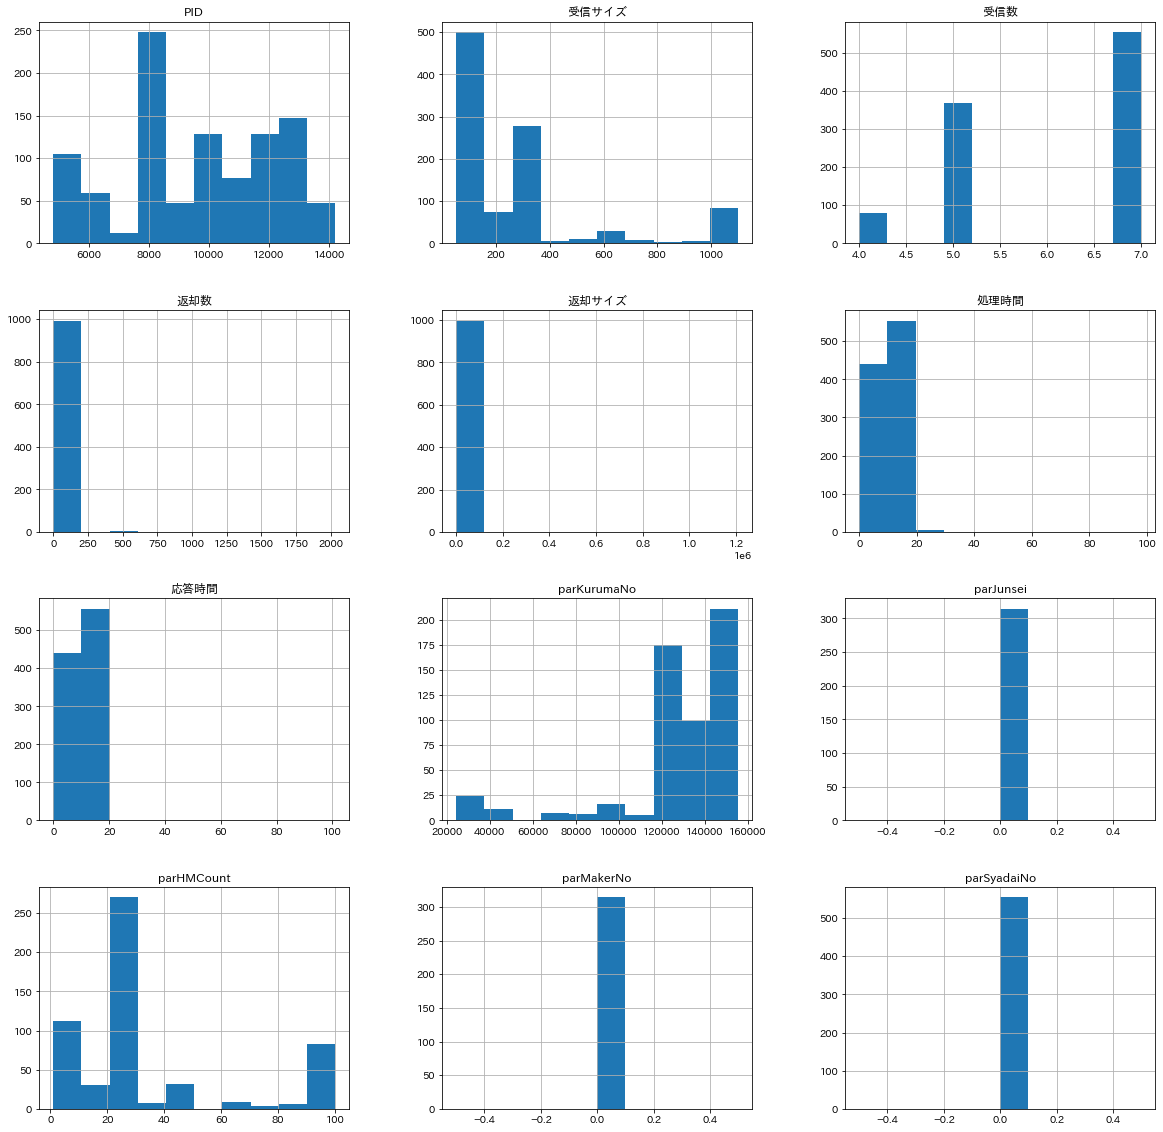

In [58]:
rcParams['figure.figsize'] = 20, 20
df_p_hist.hist()

## 出現回数
---

### 子ユーザ

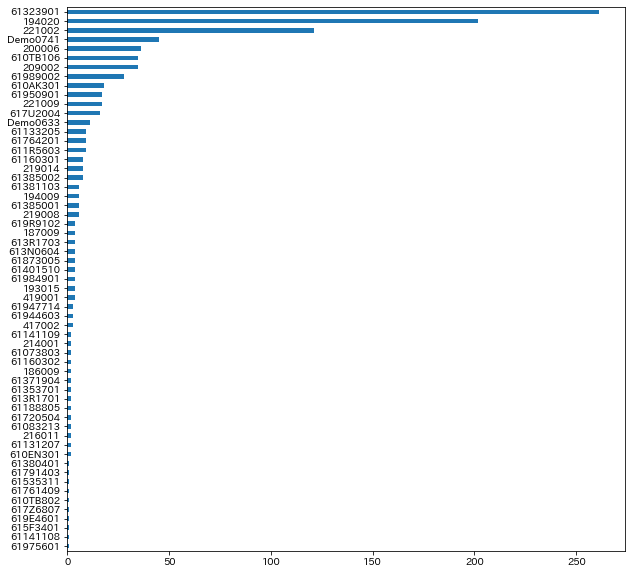

In [59]:
df_p_child_user = df_p['子ユーザ'].value_counts(sort=True)
rcParams['figure.figsize'] = 10, 10
ax = df_p_child_user.iloc[:].plot(kind="barh")
ax.invert_yaxis()

### コマンド

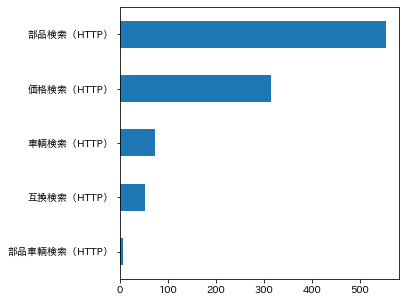

In [60]:
df_p_commands = df_p['コマンド'].value_counts(sort=True)
rcParams['figure.figsize'] = 5, 5
ax =df_p_commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

## クロス集計
---

### 子ユーザ別コマンド回数
---

In [61]:
display(pd.crosstab(df_p['子ユーザ'], df_p['コマンド']))

コマンド,互換検索（HTTP）,価格検索（HTTP）,車輌検索（HTTP）,部品検索（HTTP）,部品車輌検索（HTTP）
子ユーザ,,,,,
186009,1,1,0,0,0
187009,0,0,1,3,0
193015,0,2,0,0,2
194009,0,1,2,3,0
194020,0,8,2,192,0
200006,0,19,3,14,0
209002,0,15,5,15,0
214001,0,0,2,0,0
216011,0,1,0,0,1


# 「パラメータ等」列

## 1. parHinban

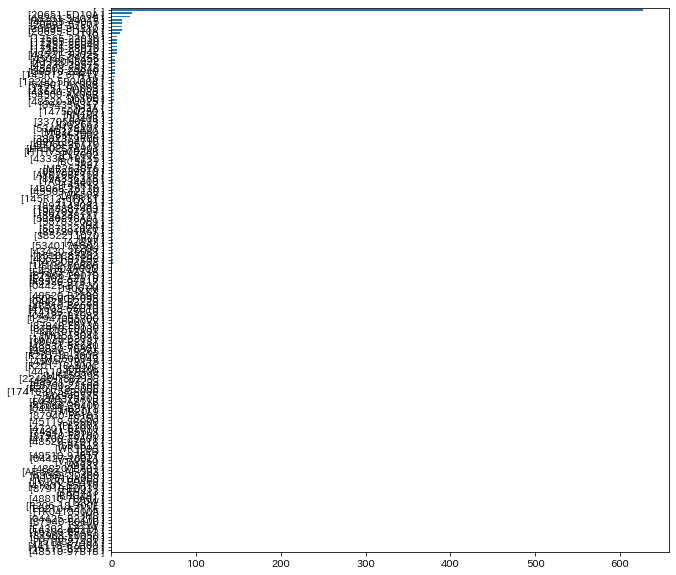

In [62]:
commands = df_p["parHinban"].value_counts(sort=True)

rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

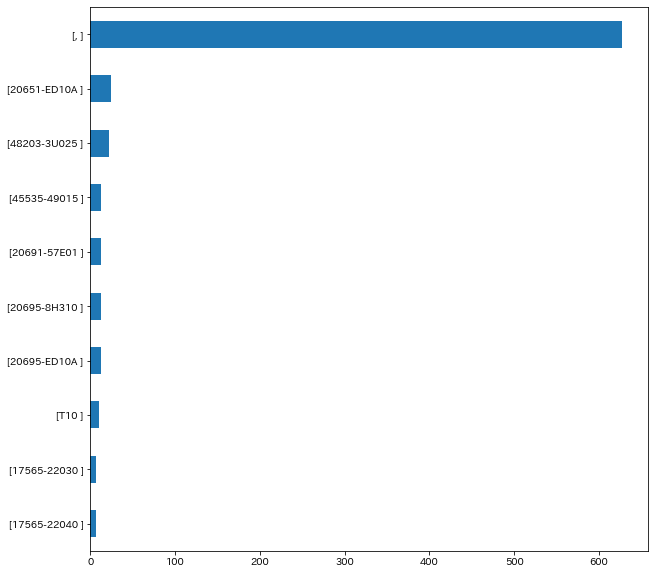

In [63]:
rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:10].plot(kind="barh")
ax.invert_yaxis()

## 2. parJunsei

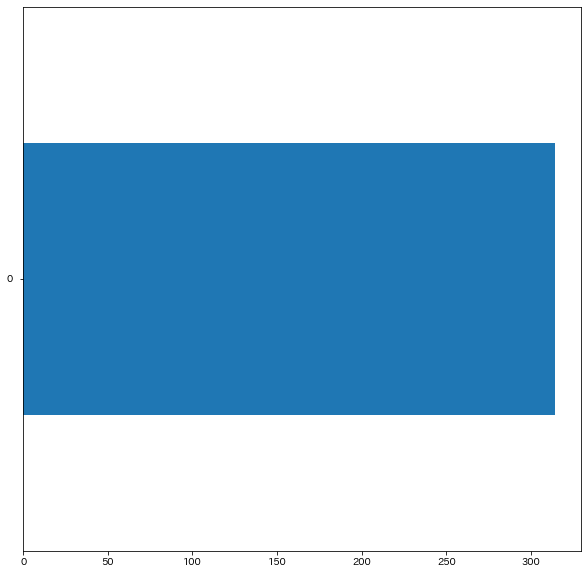

In [64]:
commands = df_p["parJunsei"].value_counts(sort=True)

rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

## 3. parType

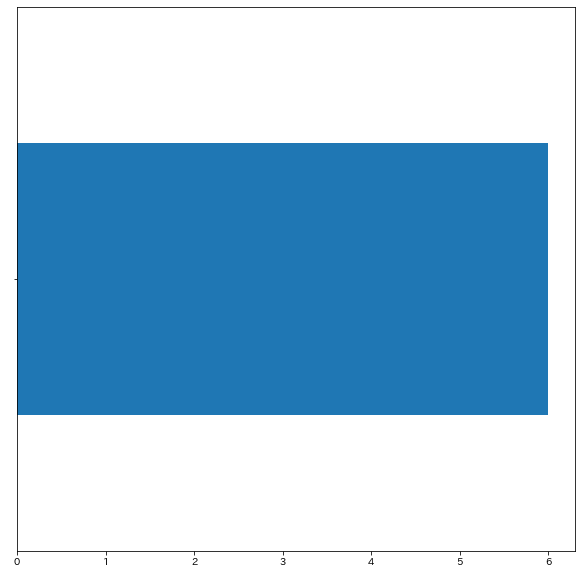

In [65]:
commands = df_p["parType"].value_counts(sort=True)

rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

## 4. parHMCount

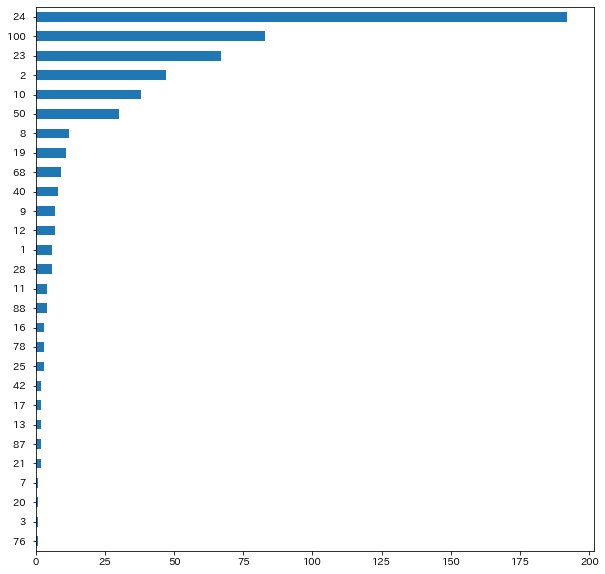

In [66]:
commands = df_p["parHMCount"].value_counts(sort=True)

rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

## 5. parMakerNo

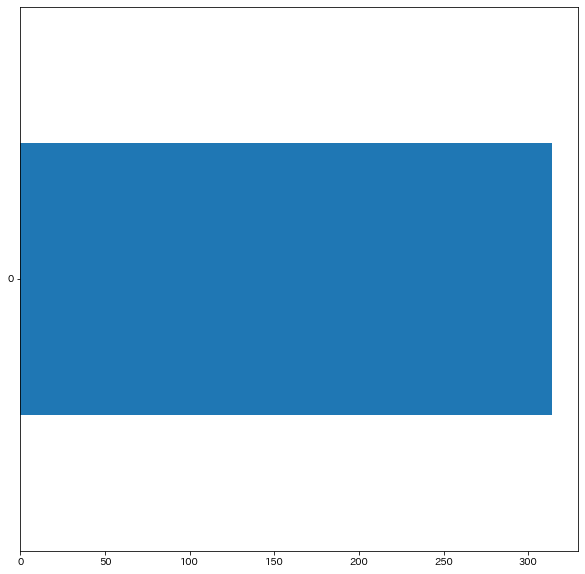

In [67]:
commands = df_p["parMakerNo"].value_counts(sort=True)

rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

## 6. parSyadaiNo

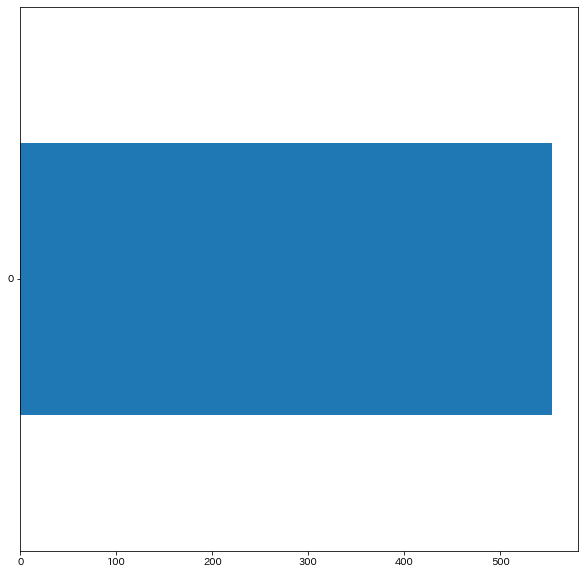

In [68]:
commands = df_p["parSyadaiNo"].value_counts(sort=True)

rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

## 7. CallHinban

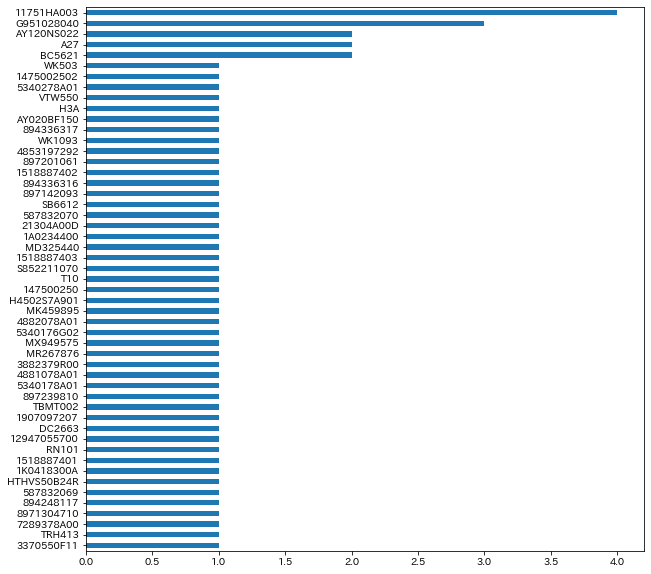

In [69]:
# 空文字列をNaNに置換
df_p["CallHinban"].replace(r'^\s*$', np.nan, regex=True, inplace=True)
# nanを削除
df_p["CallHinban"]= df_p["CallHinban"].dropna(how='any')
df_p["CallHinban"]

commands = df_p["CallHinban"].value_counts(sort=True)

rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

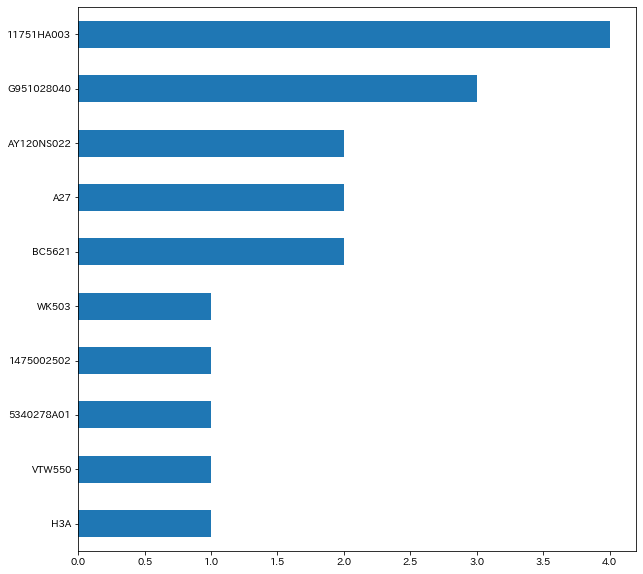

In [70]:
rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:10].plot(kind="barh")
ax.invert_yaxis()

## 8. parKurumaNo

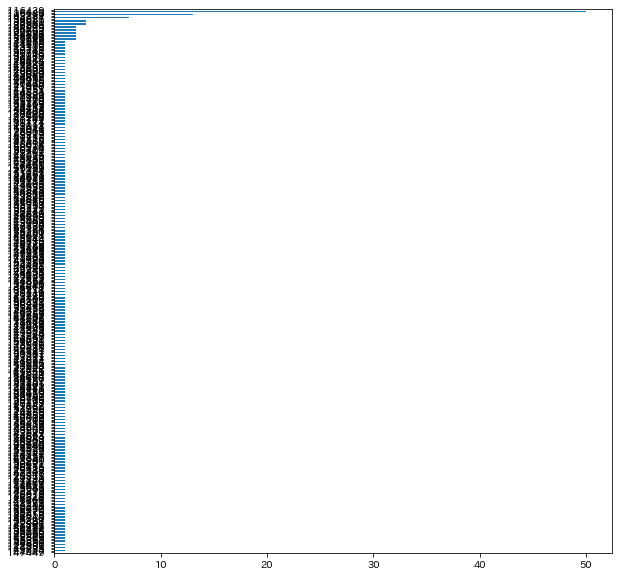

In [71]:
commands = df_p["parKurumaNo"].value_counts(sort=True)

rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:].plot(kind="barh")
ax.invert_yaxis()

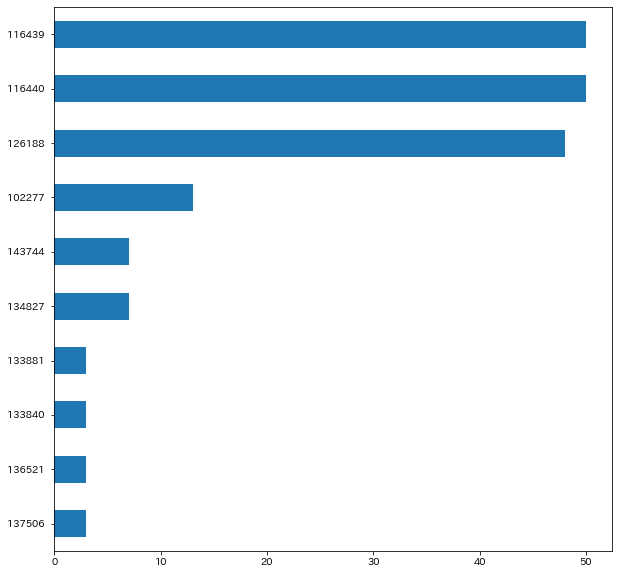

In [72]:
rcParams['figure.figsize'] = 10, 10
ax = commands.iloc[:10].plot(kind="barh")
ax.invert_yaxis()

# 複数存在するパラメータ（ / で区切られているパラメータ）

## 9. ParamList
---

In [73]:
# 複数存在するパラメータの出現回数（/区切りの要素が存在するパラメータ）
ans = sum(df_['ParamList'], [])
c = collections.Counter(ans)
df_paramList = pd.DataFrame.from_dict(c, orient='index').reset_index()
# 空文字列をNaNに置換
df_paramList.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# nanを削除
df_paramList=df_paramList.dropna(how='any')
# 半角スペースを削除
df_paramList=df_paramList[~df_paramList['index'].str.contains(' ')]
# カラム名変更

df_param_name = df_paramList[["index"]].rename(columns={"index":"ParamList"})
df_counts = df_paramList[[0]].rename(columns={0:"counts"})
df_paramList = pd.concat([df_param_name, df_counts], axis=1)
df_paramList = df_paramList.sort_values("counts", ascending=False).reset_index(drop=True)
df_paramList

,ParamList,counts
0,0001,11
1,15096,8
2,0011,4
3,16010,4
4,16011,3
...,...,...
76,0017,1
77,KE5AW,1
78,KEA5W,1
79,15659,1


### ParamList全カウント

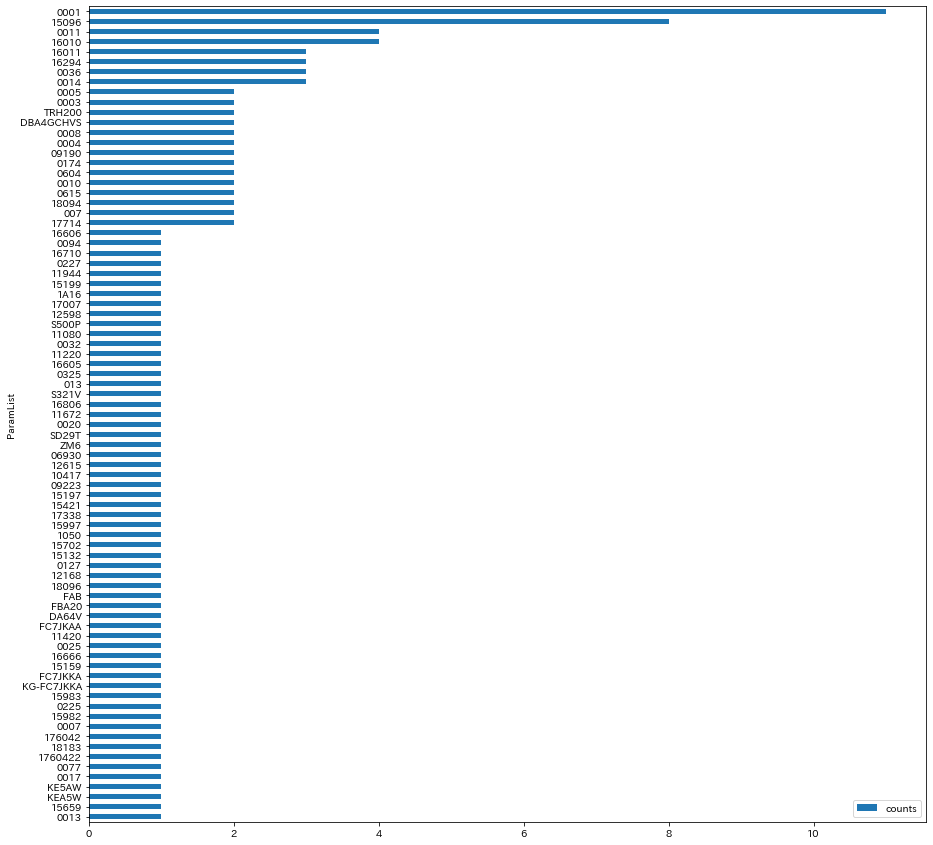

In [74]:
df_paramList = df_paramList.set_index('ParamList')
rcParams['figure.figsize'] = 15, 15
ax = df_paramList.iloc[:].plot(kind="barh")
ax.invert_yaxis()

### ParamListトップ10

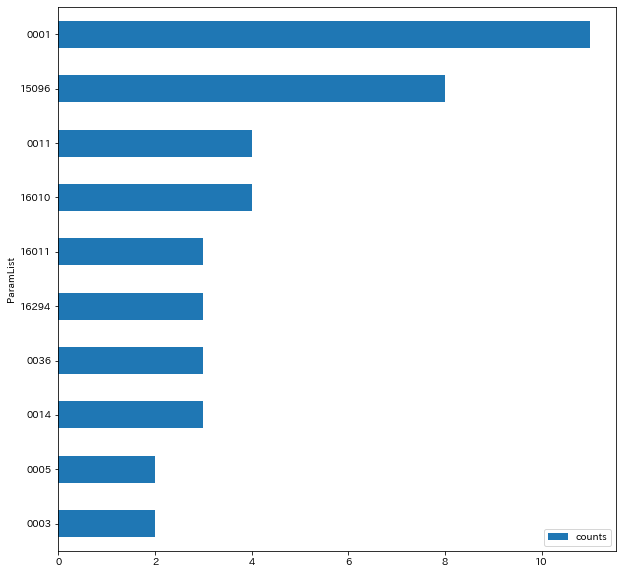

In [75]:
rcParams['figure.figsize'] = 10, 10
ax = df_paramList.iloc[:10].plot(kind="barh")
ax.invert_yaxis()

## 10. KurumaInfo
---

In [76]:
# 複数存在するパラメータの出現回数（/区切りの要素が存在するパラメータ）
ans = sum(df_['KurumaInfo'], [])
c = collections.Counter(ans)
df_paramList = pd.DataFrame.from_dict(c, orient='index').reset_index()
# 空文字列をNaNに置換
df_paramList.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# nanを削除
df_paramList=df_paramList.dropna(how='any')
# 半角スペースを削除
df_paramList=df_paramList[~df_paramList['index'].str.contains(' ')]
# カラム名変更

df_param_name = df_paramList[["index"]].rename(columns={"index":"KurumaInfo"})
df_counts = df_paramList[[0]].rename(columns={0:"counts"})
df_paramList = pd.concat([df_param_name, df_counts], axis=1)
df_paramList = df_paramList.sort_values("counts", ascending=False).reset_index(drop=True)
df_paramList

,KurumaInfo,counts
0,660,30
1,8,16
2,1,14
3,ｽｽﾞｷ,14
4,ﾄﾖﾀ,13
...,...,...
311,0017,1
312,DBA-JB5,1
313,0610,1
314,P07A,1


### KurumaInfo全カウント

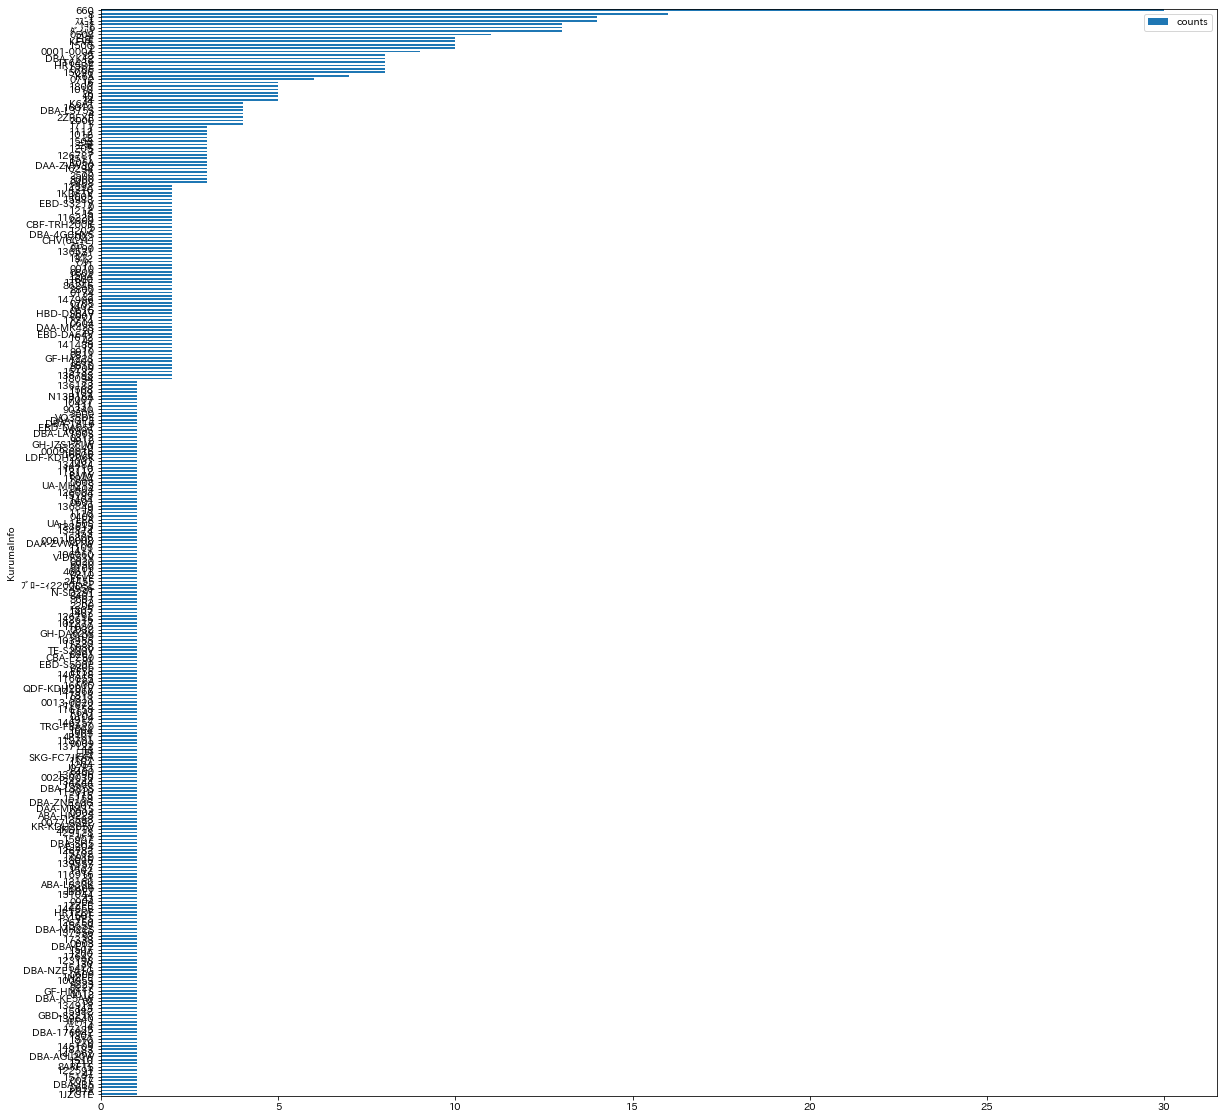

In [77]:
df_paramList = df_paramList.set_index('KurumaInfo')
rcParams['figure.figsize'] = 20, 20
ax = df_paramList.iloc[:].plot(kind="barh")
ax.invert_yaxis()

### KurumaInfoトップ１０

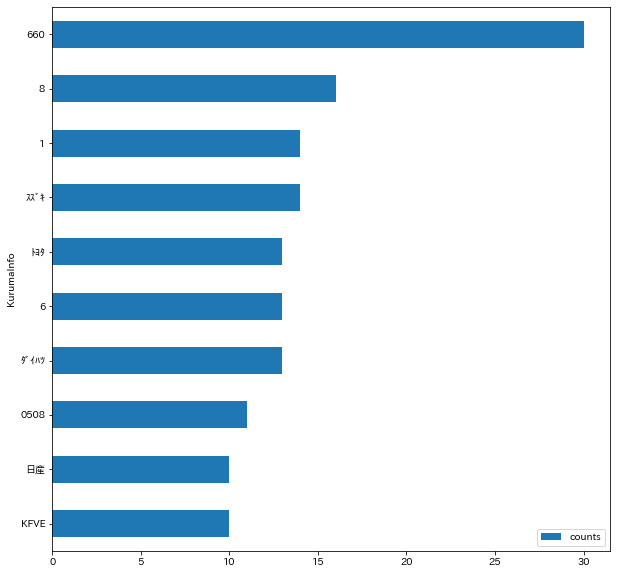

In [78]:
rcParams['figure.figsize'] = 10, 10
ax = df_paramList.iloc[:10].plot(kind="barh")
ax.invert_yaxis()

## 11. parHinmokuNos
---

In [79]:
# 複数存在するパラメータの出現回数（/区切りの要素が存在するパラメータ）
ans = sum(df_['parHinmokuNos'], [])
c = collections.Counter(ans)
df_paramList = pd.DataFrame.from_dict(c, orient='index').reset_index()
# 空文字列をNaNに置換
df_paramList.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# nanを削除
df_paramList=df_paramList.dropna(how='any')
# 半角スペースを削除
df_paramList=df_paramList[~df_paramList['index'].str.contains(' ')]
# カラム名変更

df_param_name = df_paramList[["index"]].rename(columns={"index":"parHinmokuNos"})
df_counts = df_paramList[[0]].rename(columns={0:"counts"})
df_paramList = pd.concat([df_param_name, df_counts], axis=1)
df_paramList = df_paramList.sort_values("counts", ascending=False).reset_index(drop=True)
df_paramList

,parHinmokuNos,counts
0,9830,2304
1,9840,2112
2,1022,225
3,1021,225
4,1020,222
...,...,...
383,8170,2
384,1722,2
385,2142,2
386,2948,2


### parHinmokuNos全カウント

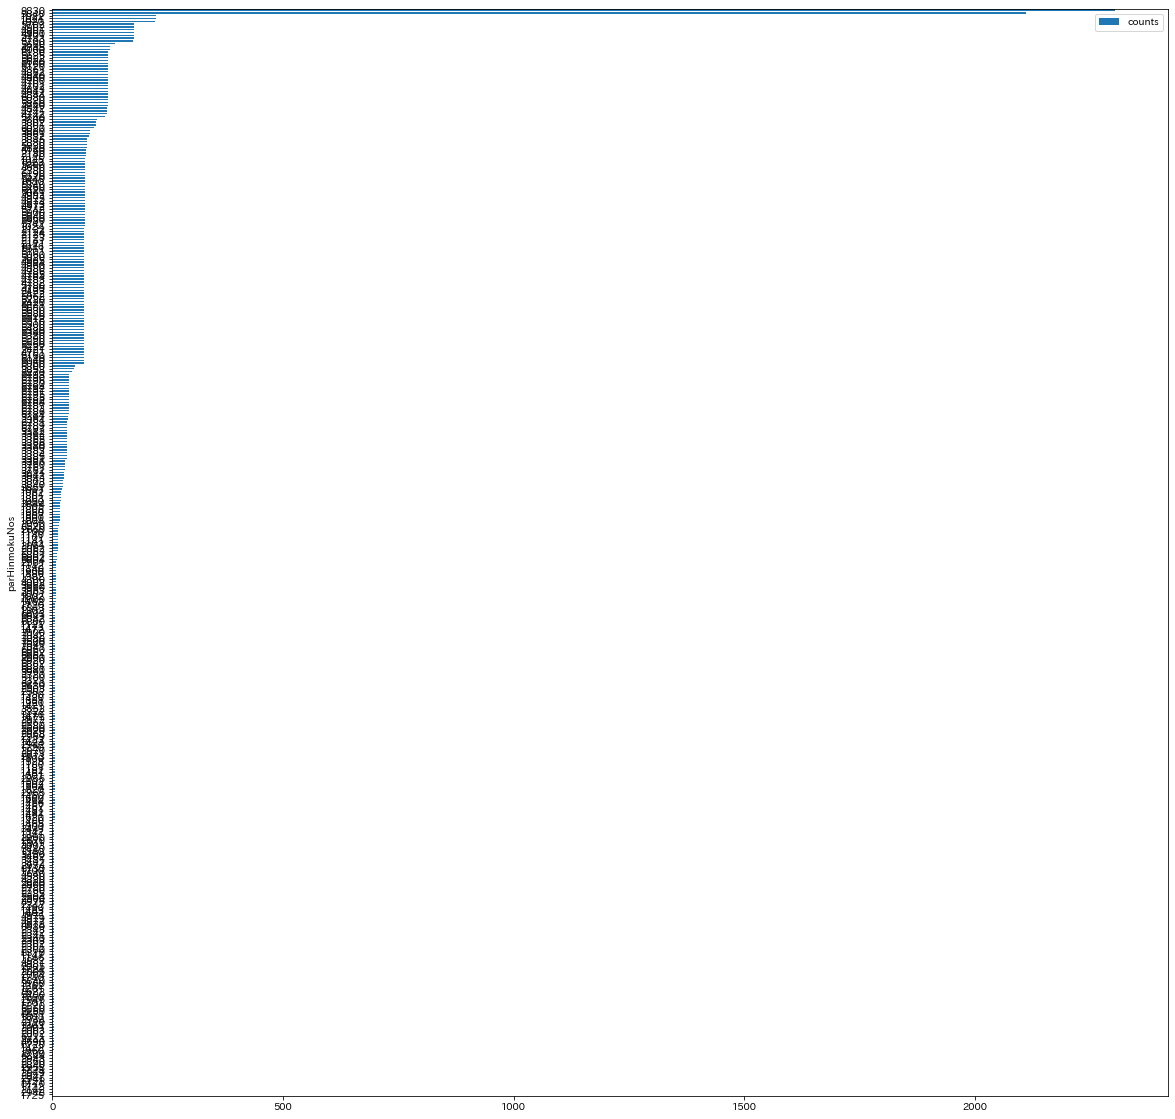

In [80]:
df_paramList = df_paramList.set_index('parHinmokuNos')
rcParams['figure.figsize'] = 20, 20
ax = df_paramList.iloc[:].plot(kind="barh")
ax.invert_yaxis()

### parHinmokuNosトップ10

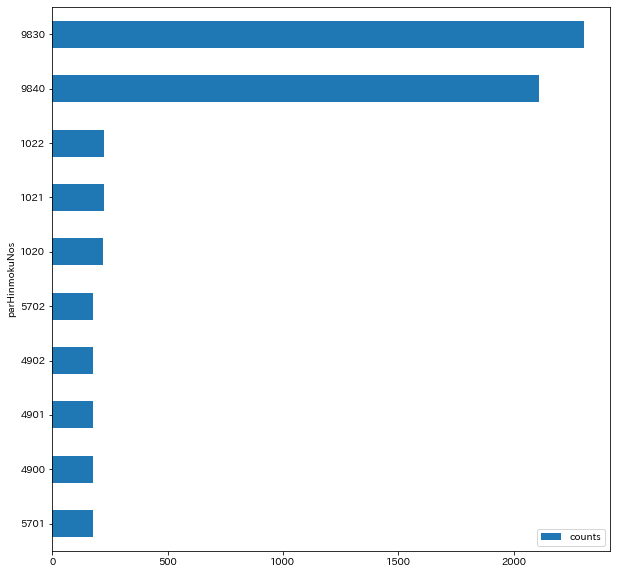

In [81]:
rcParams['figure.figsize'] = 10, 10
ax = df_paramList.iloc[:10].plot(kind="barh")
ax.invert_yaxis()

## 12. parMakerNos

In [82]:
# 複数存在するパラメータの出現回数（/区切りの要素が存在するパラメータ）
ans = sum(df_['parMakerNos'], [])
c = collections.Counter(ans)
df_paramList = pd.DataFrame.from_dict(c, orient='index').reset_index()
# 空文字列をNaNに置換
df_paramList.replace(r'^\s*$', np.nan, regex=True, inplace=True)
# nanを削除
df_paramList=df_paramList.dropna(how='any')
# 半角スペースを削除
df_paramList=df_paramList[~df_paramList['index'].str.contains(' ')]
# カラム名変更

df_param_name = df_paramList[["index"]].rename(columns={"index":"parMakerNos"})
df_counts = df_paramList[[0]].rename(columns={0:"counts"})
df_paramList = pd.concat([df_param_name, df_counts], axis=1)
df_paramList = df_paramList.sort_values("counts", ascending=False).reset_index(drop=True)
df_paramList

,parMakerNos,counts
0,2840,9203
1,4280,848
2,2280,562
3,2260,545
4,1040,513
5,0090,438
6,0050,438
7,0040,438
8,0030,438
9,0020,438


### parMakerNos全カウント

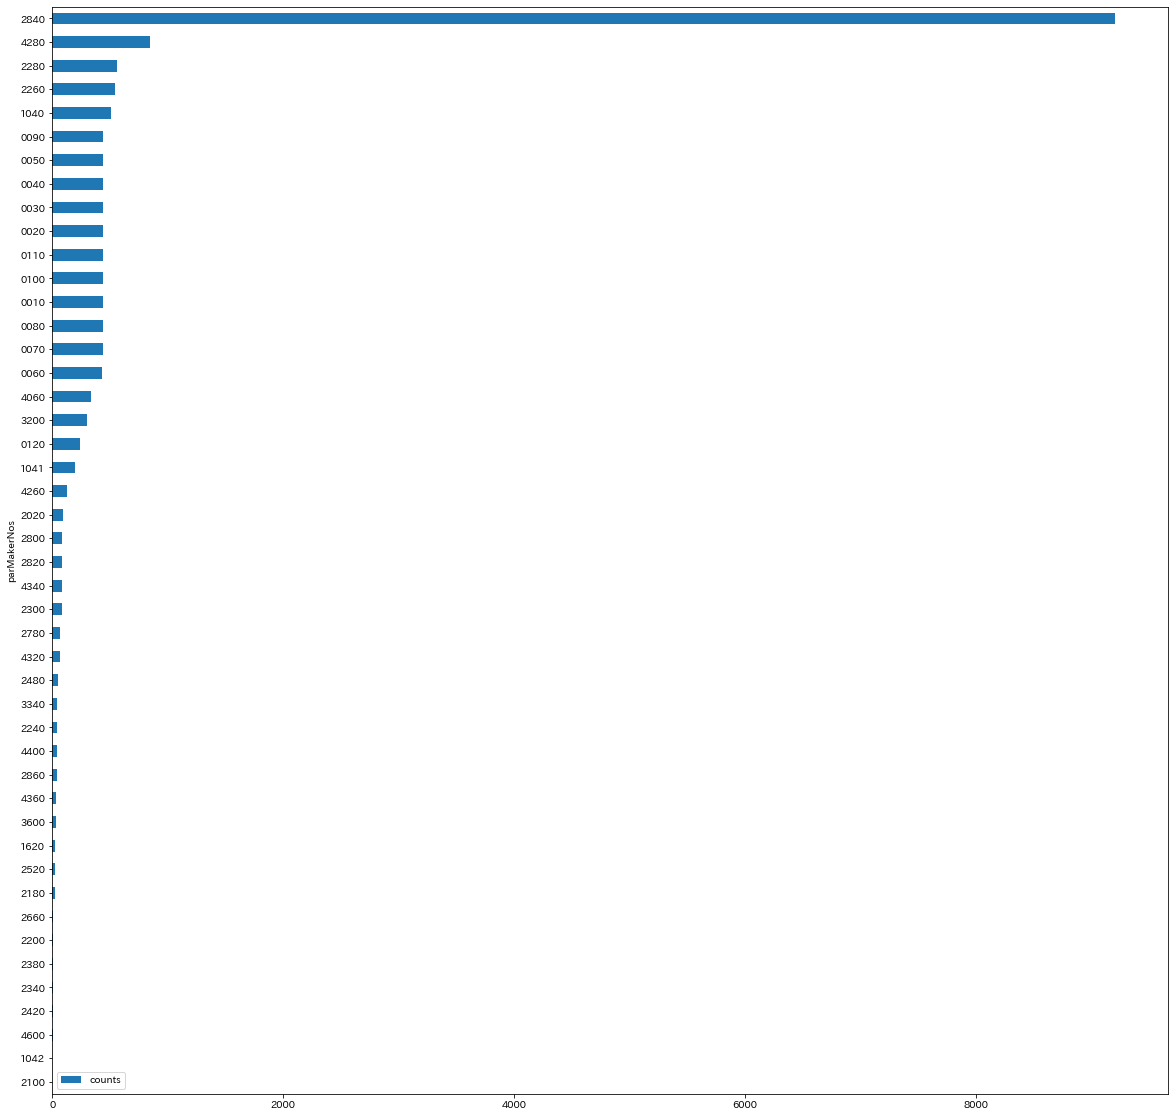

In [83]:
df_paramList = df_paramList.set_index('parMakerNos')
rcParams['figure.figsize'] = 20, 20
ax = df_paramList.iloc[:].plot(kind="barh")
ax.invert_yaxis()

### parMakerNosトップ10

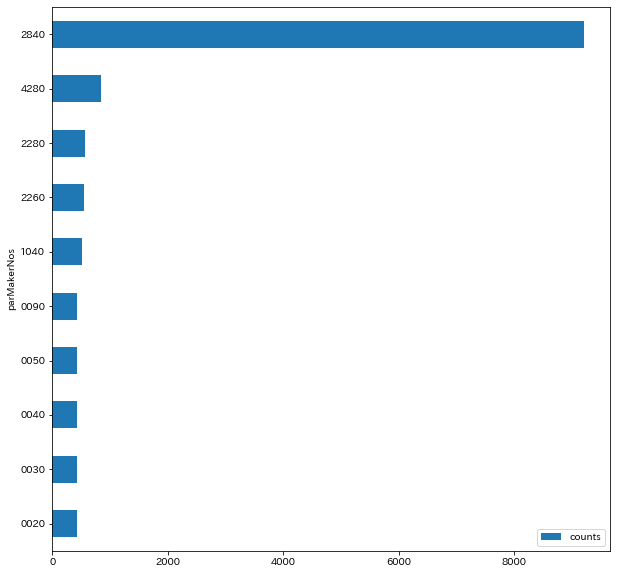

In [84]:
rcParams['figure.figsize'] = 10, 10
ax = df_paramList.iloc[:10].plot(kind="barh")
ax.invert_yaxis()

# 基本統計量
---

基本統計量はもう少し前処理をした後に行う方がよいと考える為、今回未実施

# 時系列での可視化
---

## 時間毎の出現回数変化
---

### 受信サイズ, 受信数

In [85]:
# 時刻, 受信サイズ, 受信数
df_p_ts = df_p[["時刻","受信サイズ", "受信数"]]
df_p_ts = df_p_ts.set_index('時刻')
df_p_ts

,受信サイズ,受信数
時刻,,
16:04:43,68,5
16:04:43,68,5
16:04:43,72,5
16:04:31,61,4
16:04:26,70,5
...,...,...
15:02:12,329,7
15:02:12,329,7
15:02:12,329,7


In [86]:
# グラフ領域を準備
def plot_init(title):
    fig = plt.figure()
    ax = fig.add_subplot(3,1,1)
    ax.set_title(title)
    return fig, ax

In [87]:
# プロット
def plot_count_of_day(df_p_ts):
    title = '時刻による変化'
    fig, ax = plot_init(title)
    for c in df_p_ts.columns:
        df_p_ts[c].plot(label=c, ax=ax)
    ax.legend()
    ax.set(xlabel='時刻', ylabel='count')

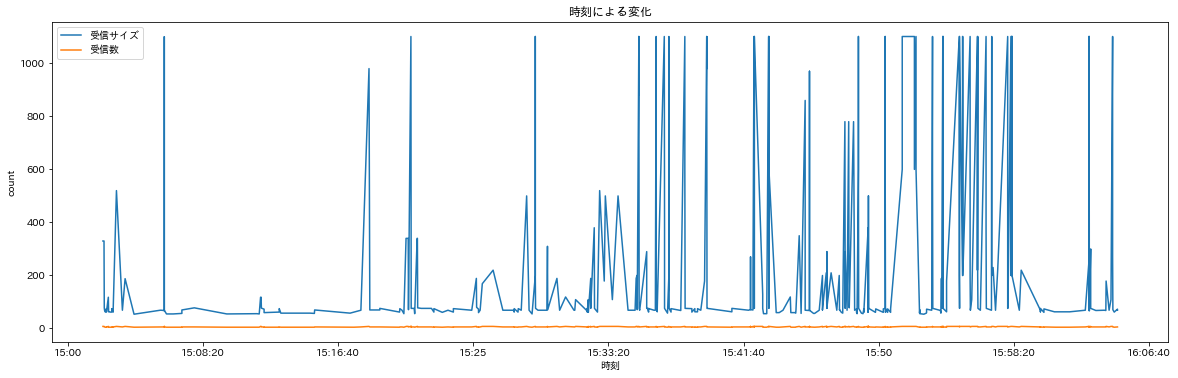

In [88]:
rcParams['figure.figsize'] = 20, 20
plot_count_of_day(df_p_ts)

In [89]:
# 子ユーザ別に時系列表示する意味はありそうか？

### 受信サイズ, 返却数

In [90]:
# 時刻, 受信サイズ, 返却数
df_p_ts = df_p[["時刻","受信サイズ", "返却数"]]
df_p_ts = df_p_ts.set_index('時刻')
df_p_ts

,受信サイズ,返却数
時刻,,
16:04:43,68,1
16:04:43,68,1
16:04:43,72,1
16:04:31,61,0
16:04:26,70,1
...,...,...
15:02:12,329,6
15:02:12,329,6
15:02:12,329,6


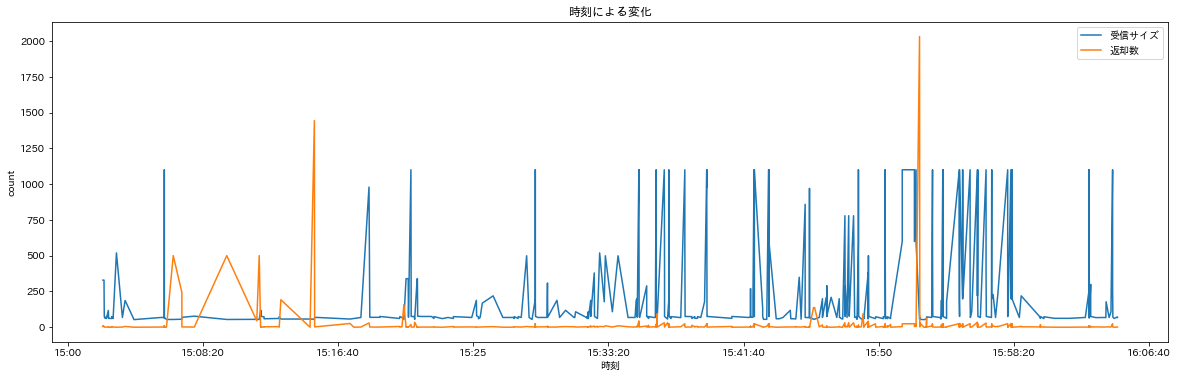

In [91]:
rcParams['figure.figsize'] = 20, 20
plot_count_of_day(df_p_ts)

子ユーザ別に時系列表示する意味はありそうか？

# 相関係数

In [92]:
df_p.head()

,月日,時刻,グローバルIP,コマンド,PID,子ユーザ,アクセス状況,受信サイズ,受信数,返却数,...,ParamList,KurumaInfo,parType,parJunsei,parHMCount,parHinmokuNos,parMakerNo,parMakerNos,parSyadaiNo,CallHinban
0,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14200,61133205,160/1321774/-1,68,5,1,...,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,NaN
1,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14199,61133205,159/1321774/-1,68,5,1,...,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,NaN
2,2021-11-09,16:04:43,3.115.81.216,価格検索（HTTP）,14198,61133205,158/1321774/-1,72,5,1,...,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,NaN
3,2021-11-09,16:04:31,54.250.12.5,互換検索（HTTP）,14167,61791403,274/3049825/-1,61,4,0,...,"[, ]","[, ]",NaN,NaN,NaN,"[, ]",None,"[, ]",None,7289378A00
4,2021-11-09,16:04:26,3.115.81.216,価格検索（HTTP）,14157,61133205,157/1321756/-1,70,5,1,...,"[, ]","[, ]",NaN,0,NaN,"[, ]",0,"[, ]",None,NaN


In [93]:
df_p_cor = df_p[["受信サイズ", "受信数", "返却数"]]

In [94]:
df_p_cor 

,受信サイズ,受信数,返却数
0,68,5,1
1,68,5,1
2,72,5,1
3,61,4,0
4,70,5,1
...,...,...,...
995,329,7,6
996,329,7,6
997,329,7,6
998,329,7,6


In [95]:
#相関係数を算出
use_data = df_p_cor.corr()

<AxesSubplot:>

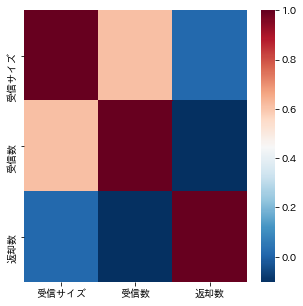

In [96]:
rcParams['figure.figsize'] = 5, 5
sns.heatmap(use_data, cmap="RdBu_r")

# （再掲）
## 0. 目的
- V8LOGデータ集計の進捗報告
  - 集計方法の妥当性確認
  - 可視化方法の確認

## 1. 進捗 

### 前処理プログラム作成
- 使用する列の抽出
  - すべてNullのカラムは削除
  - すべて同一のカラムは削除
  - 過半数がNullのカラムは削除
  - 不要な（あまり見ていない）カラムは削除
- 「パラメータ等」列の分割
  - 同一カラムに複数パラメータが入っている為、データ集計しやすいカラム、要素に分割する処理を作成

### 基礎集計
- 単純集計
- 可視化
  - 棒グラフ
  - ヒストグラム 
  - 時系列

## 2. 作成中
- 同一子ユーザが短い間隔で検索した場合、除外するまたはまとめる
-　相関のあるカラムの可視化
  - 相関係数、有意差
- 時間を指定して基礎集計、基本統計量を出力、可視化

## 3. 検証ポイント
- レコード数を増やした場合、現在（1000レコード）と異なる特徴はみられるか
- 同一子ユーザが短い間隔で検索した影響を除外した場合、現在と異なる特徴はみられるか
- 相関（有意差）をみたい項目はあるか
- 時系列で比較したい項目はあるか
  - 今回は受信サイズ, 受信数でサンプル可視化
  - 相関の高い項目を時系列で比較してみる等